In [252]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_distribution

from qiskit.circuit.library import EfficientSU2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [253]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)
    
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)

            # Use only the upper triangular part of the matrix
            if j >= i:
                if i == j:
                    pauli_operator[i] = "Z"
                    ising_value = -(1/2)*np.sum(qubo[i])
                else:
                    pauli_operator[i] = "Z"
                    pauli_operator[j] = "Z"
                    ising_value = (1/2)*qubo[i][j]

                if not ising_value == 0:
                    ising_pauli_op = (''.join(pauli_operator), ising_value)
                    operator_list.append(ising_pauli_op)

                offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators, offset

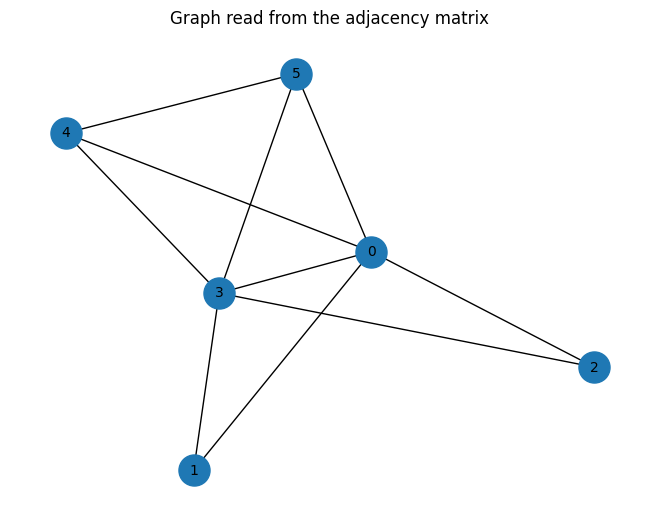

In [254]:
# Define MaxCut problem with an adjacency matrix and turn it into a QUBO matrix

adjacency_matrix = [[0, 1, 1, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0],
                    [1, 0, 0, 1, 0, 0],
                    [1, 1, 1, 0, 1, 1],
                    [1, 0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 0, 1, 0, 0, 0, 0],
#                    [1, 0, 1, 1, 0, 0, 0, 0],
#                    [0, 1, 0, 0, 0, 0, 1, 0],
#                    [1, 1, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 1, 1, 0, 0, 0],
#                    [0, 0, 1, 0, 0, 0, 0, 1],
#                    [0, 0, 0, 0, 0, 0, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

graph = nx.Graph()
vertex_number = len(adjacency_matrix)
vertex_list = []
for i in range(vertex_number):
    vertex_list.append(i)
    for j in range(vertex_number):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

num_nodes = graph.number_of_nodes()
Q = np.eye(num_nodes)

for i in range(len(adjacency_matrix[0])):
    sum = 0
    for j in range(len(adjacency_matrix[0])):
        sum = sum + adjacency_matrix[i][j]
        if adjacency_matrix[i][j] == 1 and not i == j:
            Q[i][j] = 1
    Q[i][i] = -sum

edge_list = list(graph.edges())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Graph read from the adjacency matrix")
plt.show()

In [255]:
# Define an ansatz circuit for VQE
ansatz = EfficientSU2(len(Q))

In [256]:
hamiltonian, offset = convert_qubo_to_ising(Q)

In [257]:
# Run the VQE
vqe = VQE(Estimator(), ansatz, SLSQP())
vqe_result = vqe.compute_minimum_eigenvalue(hamiltonian)

In [258]:
print("Result:", vqe_result.eigenvalue + offset)

Result: -7.999999571112398


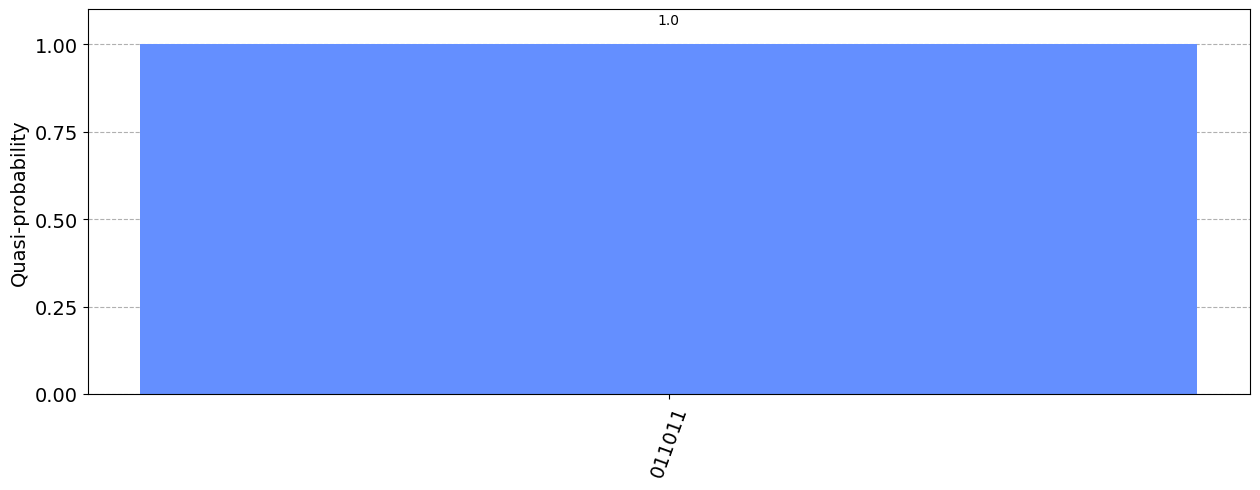

In [259]:
backend = AerSimulator()

qc_assigned_parameters = vqe_result.optimal_circuit.assign_parameters(vqe_result.optimal_parameters)
qc_transpiled = transpile(qc_assigned_parameters, backend=backend)
qc_transpiled.measure_all()

counts = backend.run(qc_transpiled, shots=50000).result().get_counts()

plot_distribution(counts, figsize=(15, 5))

In [260]:
highest_possible_solution = 0
max_count = 0
for key, count in counts.items():
    if count > max_count:
        max_count = count
        highest_possible_solution = key
print(f"Highest possible solution: {highest_possible_solution}")

# Convert string to array
X = np.fromstring(highest_possible_solution, np.int8) - 48

# Calculate the result using the highest possible solution
E = X.T @ Q @ X

print(f"Result: {E}")

Highest possible solution: 011011
Result: -8.0


C:\Users\tpihkako19\AppData\Local\Temp\ipykernel_14136\1529694762.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X = np.fromstring(highest_possible_solution, np.int8) - 48


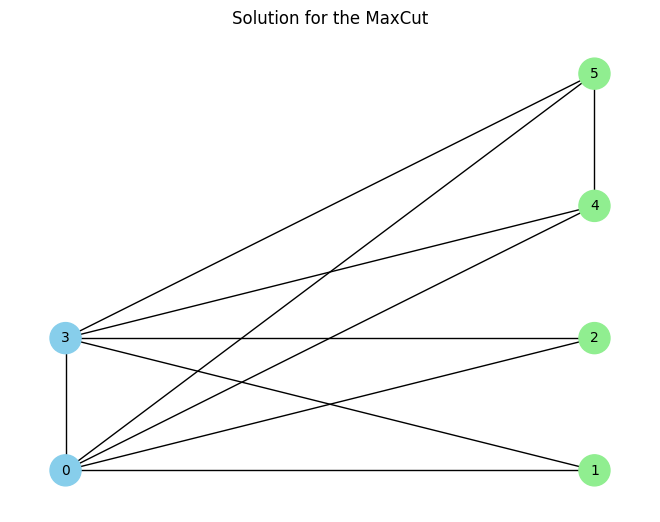

In [261]:
graph = nx.Graph()
group_1 = []
group_2 = []
vertex_number = len(highest_possible_solution)
for i in range(vertex_number):
    if highest_possible_solution[i] == "0":
        group_1.append(i)
    elif highest_possible_solution[i] == "1":
        group_2.append(i)
    else:
        print("No valid solution")
graph.add_nodes_from(group_1, bipartite=0)
graph.add_nodes_from(group_2, bipartite=1)
graph.add_edges_from(edge_list)
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(group_1))
pos.update((n, (2, i)) for i, n in enumerate(group_2))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10, node_color=['skyblue'] * len(group_1) + ['lightgreen'] * len(group_2))
plt.title("Solution for the MaxCut")
plt.show()